# Project 3: Gaussian Mixture Model
\
- Features will be selected using Uniform Manifold Approximation and Projection (UMAP), in order to project the features in lower dimensions to visualize the clustering results and decrease computational complexity.

- The number of clusters where selected using cross validation with two methods:
    - Silhouette score
    - Elbow method



### Libraries

In [ ]:
# General purpose:
import pandas as pd
import numpy as np
from itertools import combinations
import warnings

# Visualization:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Data formatting and modelling:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.mixture import GaussianMixture
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import silhouette_score, adjusted_rand_score
import pca
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


### Importing Data

In [308]:
# Load catdog data set:
df_catdog = pd.read_csv('../project_2/catdogdata.txt', delimiter = ' ')
df_catdog['label'] = 0 # cats are the first 99 entries
df_catdog.loc[99:198, 'label'] = 1 # dogs are the next 99 entries

# Rotate all images 90 degrees clockwise
def rotate_image(image):
    return np.rot90(image.reshape(64, 64), -1).flatten()

# Apply the rotation to all rows and update the DataFrame
rotated_images = np.array([rotate_image(row.values) for _, row in df_catdog.iloc[:, :-1].iterrows()])
df_catdog.iloc[:, :-1] = rotated_images

# Load MNIST data set
df_mnist = pd.read_csv('../project_2/Numbers.txt', delimiter=' ')
df_mnist['label'] = df_mnist.iloc[:, 0]
df_mnist = df_mnist.iloc[:, 1:]


### 2D projection

In [334]:
# pca 2D projection of catdog data set
X_catdog = df_catdog.iloc[:, :-1].values
y_catdog = df_catdog.iloc[:, -1].values
X_catdog = StandardScaler().fit_transform(X_catdog)
pca_catdog = PCA(n_components=2, random_state=42)
X_catdog_pca = pca_catdog.fit_transform(X_catdog)

# pca 2D projection of MNIST data set
X_mnist = df_mnist.iloc[:, :-1].values
y_mnist = df_mnist.iloc[:, -1].values
X_mnist = StandardScaler().fit_transform(X_mnist)
pca_mnist = PCA(n_components=2, random_state=42)
X_mnist_pca = pca_mnist.fit_transform(X_mnist)


### PCA

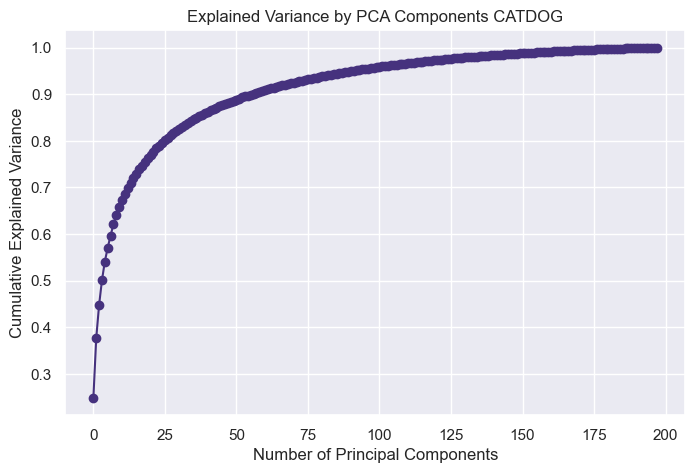

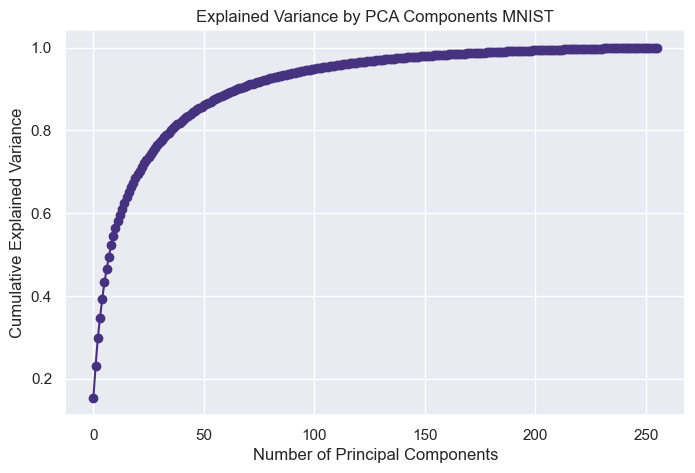

In [336]:
X = X_catdog  # assuming df is your feature-only DataFrame
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components CATDOG')
plt.grid(True)
plt.show()

X = X_mnist  # assuming df is your feature-only DataFrame
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components MNIST')
plt.grid(True)
plt.show()

### Plot UMAP projections

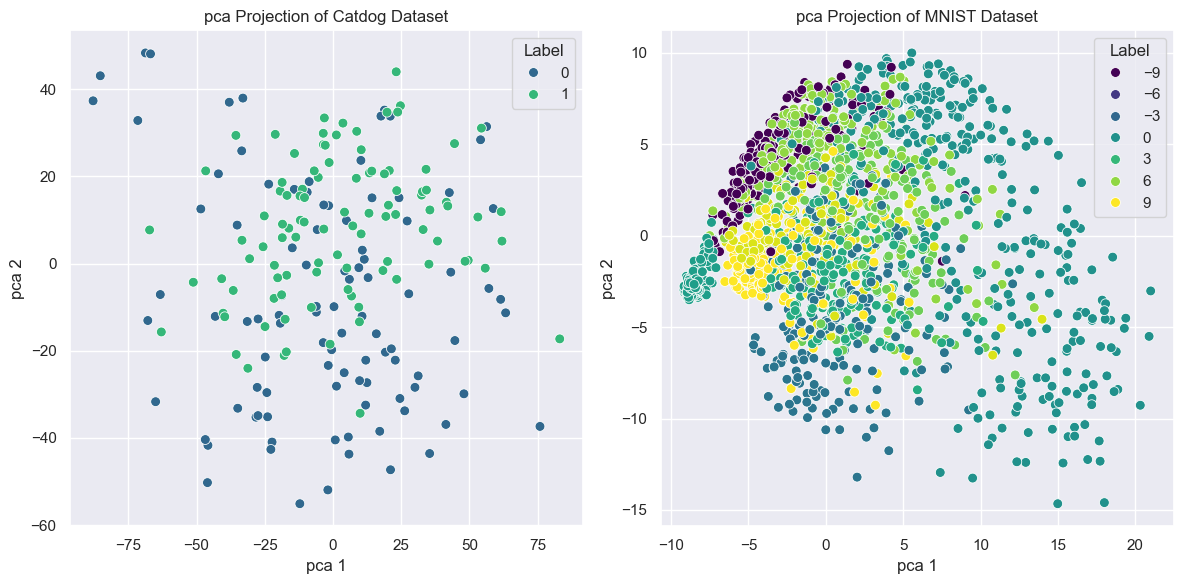

In [337]:
# Plot 2D projections
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.set(style="darkgrid", palette="viridis")

# Catdog
sns.scatterplot(x=X_catdog_pca[:, 0], y=X_catdog_pca[:, 1], hue=y_catdog, palette='viridis', s=50, ax=ax1)
ax1.set_title('pca Projection of Catdog Dataset')
ax1.set_xlabel('pca 1')
ax1.set_ylabel('pca 2')
ax1.legend(title='Label')

# MNIST 
sns.scatterplot(x=X_mnist_pca[:, 0], y=X_mnist_pca[:, 1], hue=y_mnist, palette='viridis', s=50, ax=ax2)
ax2.set_title('pca Projection of MNIST Dataset')
ax2.set_xlabel('pca 1')
ax2.set_ylabel('pca 2')
ax2.legend(title='Label')

plt.tight_layout()
plt.show()

### Function for visualization

In [338]:
def plot_gmm_and_true_labels(X, y_pred, y_true, gmm_model, label_names=None, title="GMM Clustering with True Labels", cont = False):
    """
    Plots GMM clustering results with decision boundaries alongside true labels.

    Parameters:
    - X: 2D numpy array of shape (n_samples, 2), the pca-reduced data.
    - y_true: 1D array-like of true labels (e.g., [0, 1]).
    - gmm_model: A fitted sklearn.mixture.GaussianMixture instance.
    - label_names: Optional dict mapping label values to strings (e.g., {0: "Cat", 1: "Dog"}).
    - title: Title of the entire figure.
    """
    n_components = 20
    colors = sns.color_palette("tab20", n_components)
    cmap = ListedColormap(colors)
    n_components = gmm_model.n_components
    # Set seaborn style
    sns.set(style="darkgrid", palette="viridis")

    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))
    if cont:
        # GMM predictions with decision boundary
        DecisionBoundaryDisplay.from_estimator(
            gmm_model, X, response_method="predict", ax=ax1,
            alpha=0.6, cmap=cmap
        )

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                            np.linspace(y_min, y_max, 300))
        Z = gmm_model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

    sns.scatterplot(
        x=X[:, 0], y=X[:, 1], hue=y_pred,
        palette=colors, edgecolor="k", s=60, ax=ax1, legend=False
    )
    ax1.set_title("GMM Clustering", fontsize=14)
    ax1.set_xlabel("pca 1")
    ax1.set_ylabel("pca 2")
    if cont:
        ax1.contour(xx, yy, Z, levels=np.arange(n_components + 1) - 0.5, 
                 colors='black', linewidths=1.5)

    # True labels
    sns.scatterplot(
        x=X[:, 0], y=X[:, 1], hue=y_true,
        palette=colors, edgecolor="k", s=60, ax=ax2, legend=True
    )
    ax2.set_title("True Labels", fontsize=14)
    ax2.set_xlabel("pca 1")
    ax2.set_ylabel("pca 2")

    # Custom legend if label names are provided
    if label_names:
        handles, _ = ax2.get_legend_handles_labels()
        sorted_labels = sorted(set(y_true))
        ax2.legend(handles=handles, labels=[label_names[i] for i in sorted_labels], title="Label")

    # Final formatting
    plt.suptitle(title, fontsize=16, y=1.03)
    sns.despine()
    plt.tight_layout()
    plt.show()


### Cross Validation for optimal number of clusters

In [339]:
def tune_gmm_params(X, param_grid, n_splits=5, random_state=42):
    records = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for k in param_grid:
        for fold, (train_idx, _) in enumerate(kf.split(X)):
            X_train = X[train_idx]

            gmm = GaussianMixture(n_components=k, random_state=random_state)
            gmm.fit(X_train)
            labels = gmm.predict(X_train)
            centers = gmm.means_

            # Compute SSE
            sse = np.sum([
                np.linalg.norm(x - centers[label]) ** 2
                for x, label in zip(X_train, labels)
            ])

            # Compute silhouette score (only if k > 1)
            if k > 1:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    sil_score = silhouette_score(X_train, labels)
            else:
                sil_score = np.nan

            records.append({
                "n_clusters": k,
                "fold": fold,
                "silhouette": sil_score,
                "sum_sq_error": sse
            })

    df = pd.DataFrame(records)

    # Aggregate means across folds
    summary = df.groupby("n_clusters").agg({
        "silhouette": "mean",
        "sum_sq_error": "mean"
    }).reset_index()

    # Elbow detection function
    def find_elbow(x, y):
        x = np.array(x)
        y = np.array(y)
        p1, p2 = np.array([x[0], y[0]]), np.array([x[-1], y[-1]])
        line = p2 - p1
        line_norm = line / np.linalg.norm(line)
        distances = [
            np.linalg.norm((np.array([xi, yi]) - p1) - np.dot((np.array([xi, yi]) - p1), line_norm) * line_norm)
            for xi, yi in zip(x, y)
        ]
        return x[np.argmax(distances)]

    best_k_silhouette = summary.loc[summary['silhouette'].idxmax(), 'n_clusters']
    best_k_elbow = find_elbow(summary['n_clusters'], summary['sum_sq_error'])

    return df, summary, best_k_silhouette, best_k_elbow


### Stability analysis
An outer loop that re-runs the crossvalidation to check stability via ARI.

In [340]:
def assess_tuning_stability(X, param_grid, n_runs=10, n_splits=5):
    
    all_labels_ss = []
    all_labels_elbow = []
    list_best_k_ss = []
    list_best_k_elbow = []
    

    df_results = pd.DataFrame(columns=["n_clusters", "fold", "silhouette", "sum_sq_error","run"])

    for i in range(n_runs):
        X_resampled = resample(X, replace=True, random_state=42 + i)
        df_temp_tune, summary_temp_tune, best_k_ss, best_k_elbow = tune_gmm_params(X_resampled, param_grid, n_splits=n_splits, random_state=42 + i)
        df_temp_tune['run'] = i

        df_results = pd.concat([df_results, df_temp_tune], ignore_index=True)


        gmm_ss = GaussianMixture(n_components=best_k_ss).fit(X_resampled)
        labels_ss = gmm_ss.predict(X_resampled)
        all_labels_ss.append(labels_ss)
        list_best_k_ss.append(best_k_ss)

        gmm_elbow = GaussianMixture(n_components=best_k_elbow).fit(X_resampled)
        labels_elbow = gmm_elbow.predict(X_resampled)
        all_labels_elbow.append(labels_elbow)
        list_best_k_elbow.append(best_k_elbow)

    aris_ss = [adjusted_rand_score(all_labels_ss[i], all_labels_ss[j])
            for i, j in combinations(range(n_runs), 2)]
    
    aris_elbow = [adjusted_rand_score(all_labels_elbow[i], all_labels_elbow[j])
            for i, j in combinations(range(n_runs), 2)]

    print(f"##### Metrics using Silhouette score: #####\nAverage ARI across {n_runs} tuning runs: {np.mean(aris_ss):.4f}")
    print(f"Best k's across runs: {list_best_k_ss}")

    print(f"##### Metrics using Elbow method: #####\nAverage ARI across {n_runs} tuning runs: {np.mean(aris_elbow):.4f}")
    print(f"Best k's across runs: {list_best_k_elbow}")
    
    return aris_ss, list_best_k_ss, aris_elbow, list_best_k_elbow, df_results

### Split the data into a houldout set.

In [341]:
X_catdog_train, X_catdog_test, y_catdog_train, y_catdog_test = train_test_split(
    X_catdog_pca, y_catdog, test_size=0.2, random_state=42, stratify=y_catdog
)

# Split MNIST dataset
X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(
    X_mnist_pca, y_mnist, test_size=0.2, random_state=42, stratify=y_mnist
)

### Run the CV tuning and Stability analysis

In [342]:
aris_ss_catdog, k_best_ss_catdog, aris_elbow_catdog , k_best_elbow_catdog, df_runs_catdog = assess_tuning_stability(X_catdog_train, [x for x in range(1,10)], 10, 5)

aris_ss_mnist, k_best_ss_mnist, aris_elbow_mnist , k_best_elbow_mnist, df_runs_mnist = assess_tuning_stability(X_mnist_train, [x for x in range(6,30)], 10, 5)


C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\3178203667.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, df_temp_tune], ignore_index=True)


##### Metrics using Silhouette score: #####
Average ARI across 10 tuning runs: 0.0024
Best k's across runs: [np.int64(2), np.int64(9), np.int64(5), np.int64(7), np.int64(5), np.int64(6), np.int64(4), np.int64(5), np.int64(8), np.int64(4)]
##### Metrics using Elbow method: #####
Average ARI across 10 tuning runs: 0.0049
Best k's across runs: [np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(5), np.int64(2), np.int64(4)]


C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\3178203667.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, df_temp_tune], ignore_index=True)


##### Metrics using Silhouette score: #####
Average ARI across 10 tuning runs: 0.0002
Best k's across runs: [np.int64(14), np.int64(12), np.int64(6), np.int64(12), np.int64(13), np.int64(11), np.int64(9), np.int64(25), np.int64(13), np.int64(12)]
##### Metrics using Elbow method: #####
Average ARI across 10 tuning runs: -0.0001
Best k's across runs: [np.int64(14), np.int64(12), np.int64(13), np.int64(12), np.int64(13), np.int64(13), np.int64(14), np.int64(13), np.int64(13), np.int64(12)]


# Validation

### MNIST

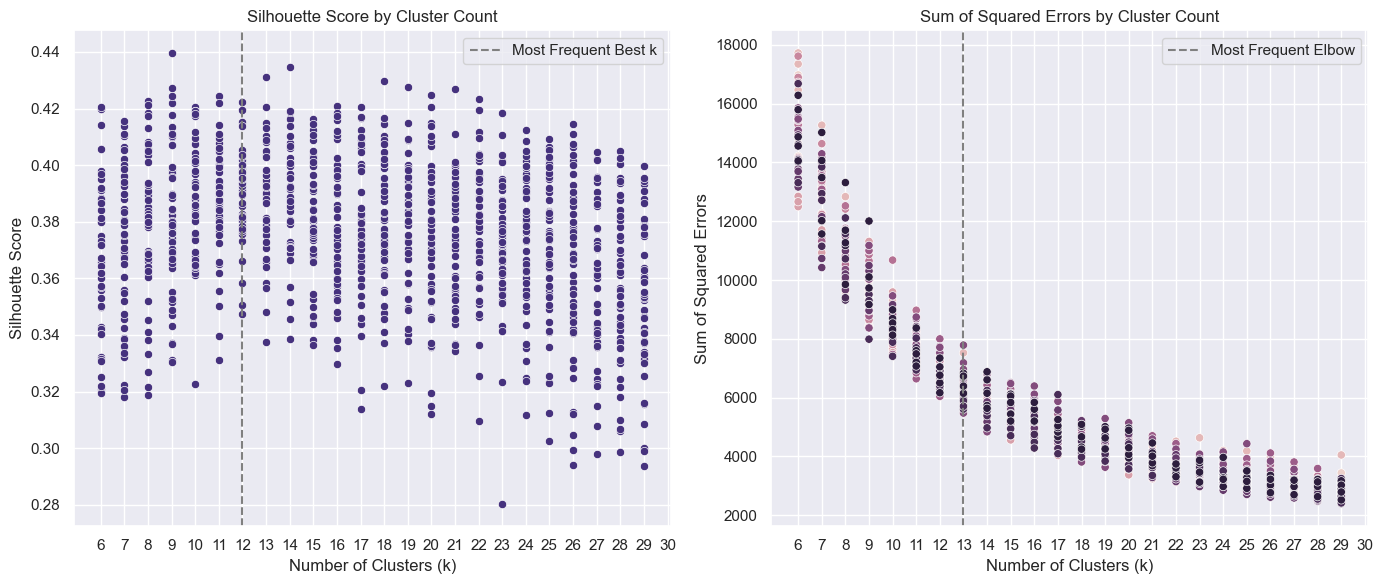

In [343]:
values, counts = np.unique(k_best_ss_mnist, return_counts=True)
most_frequent_k_ss = values[np.argmax(counts)]

values, counts = np.unique(k_best_elbow_mnist, return_counts=True)
most_frequent_k_elbow = values[np.argmax(counts)]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

xticks_range = list(range(6, 31))

sns.scatterplot(data=df_runs_mnist, x='n_clusters', y='silhouette', marker='o', ax=ax1, legend=False)
ax1.axvline(most_frequent_k_ss, color='gray', linestyle='--', label='Most Frequent Best k')
ax1.set_title('Silhouette Score by Cluster Count')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.legend()
ax1.set_xticks(xticks_range)

# Plot 2: Sum of Squared Errors
sns.scatterplot(data=df_runs_mnist, x='n_clusters', y='sum_sq_error', hue="run", marker='o', ax=ax2, legend=False)
ax2.axvline(most_frequent_k_elbow, color='gray', linestyle='--', label='Most Frequent Elbow')
ax2.set_title('Sum of Squared Errors by Cluster Count')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Sum of Squared Errors')
ax2.legend()
ax2.set_xticks(xticks_range)

plt.tight_layout()
plt.show()


ARI using Silhouette: 0.3365961917734716


C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:35: UserWarning: The palette list has more values (20) than needed (12), which may not be intended.
  sns.scatterplot(
C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:47: UserWarning: The palette list has more values (20) than needed (9), which may not be intended.
  sns.scatterplot(


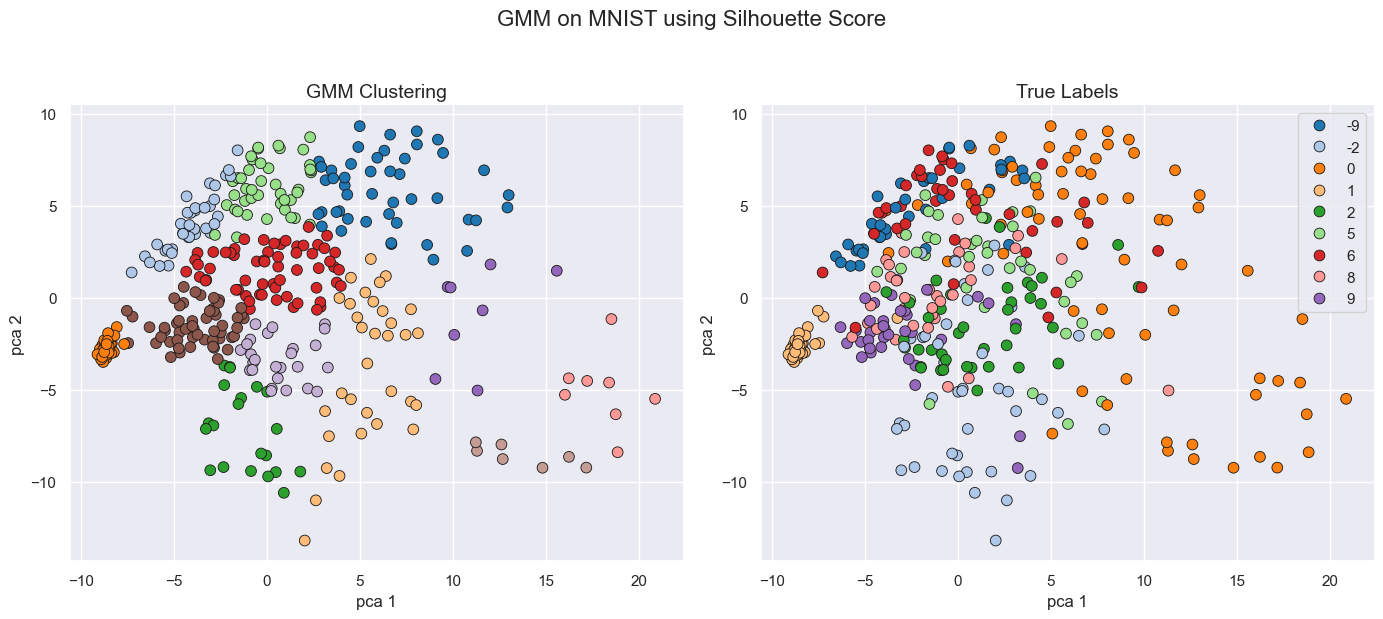

ARI using Elbow: 0.33616626618695816


C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:35: UserWarning: The palette list has more values (20) than needed (13), which may not be intended.
  sns.scatterplot(
C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:47: UserWarning: The palette list has more values (20) than needed (9), which may not be intended.
  sns.scatterplot(


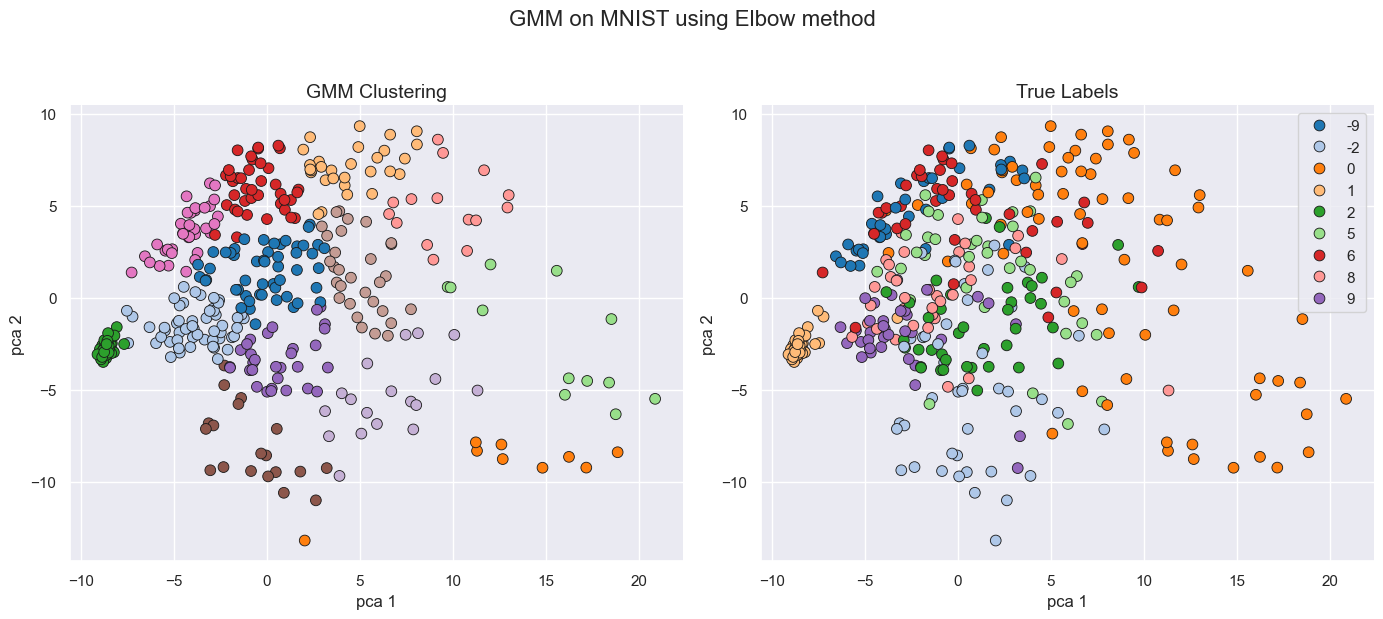

In [344]:
gmm_mnist = GaussianMixture(n_components=most_frequent_k_ss).fit(X_mnist_train)
y_mnist_pred = gmm_mnist.predict(X_mnist_test)
ari_mnist = adjusted_rand_score(y_mnist_test, y_mnist_pred)
print(f"ARI using Silhouette: {ari_mnist}")
plot_gmm_and_true_labels(X_mnist_test,y_mnist_pred, y_mnist_test, gmm_mnist, title="GMM on MNIST using Silhouette Score")

gmm_mnist = GaussianMixture(n_components=most_frequent_k_elbow).fit(X_mnist_train)
y_mnist_pred = gmm_mnist.predict(X_mnist_test)
ari_mnist = adjusted_rand_score(y_mnist_test, y_mnist_pred)
print(f"ARI using Elbow: {ari_mnist}")
plot_gmm_and_true_labels(X_mnist_test,y_mnist_pred, y_mnist_test, gmm_mnist, title="GMM on MNIST using Elbow method")



### Catdog

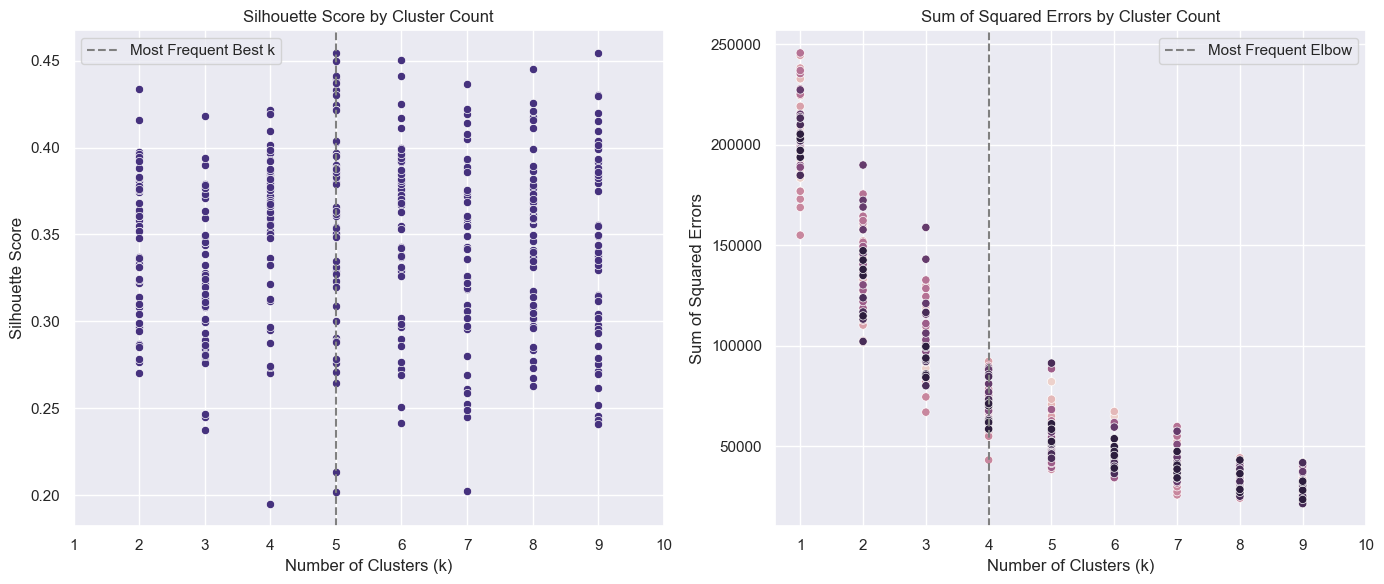

In [345]:
values, counts = np.unique(k_best_ss_catdog, return_counts=True)
most_frequent_k_ss = values[np.argmax(counts)]

values, counts = np.unique(k_best_elbow_catdog, return_counts=True)
most_frequent_k_elbow = values[np.argmax(counts)]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

xticks_range = list(range(1, 11))

sns.scatterplot(data=df_runs_catdog, x='n_clusters', y='silhouette', marker='o', ax=ax1, legend=False)
ax1.axvline(most_frequent_k_ss, color='gray', linestyle='--', label='Most Frequent Best k')
ax1.set_title('Silhouette Score by Cluster Count')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.legend()
ax1.set_xticks(xticks_range)

# Plot 2: Sum of Squared Errors
sns.scatterplot(data=df_runs_catdog, x='n_clusters', y='sum_sq_error', hue="run", marker='o', ax=ax2, legend=False)
ax2.axvline(most_frequent_k_elbow, color='gray', linestyle='--', label='Most Frequent Elbow')
ax2.set_title('Sum of Squared Errors by Cluster Count')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Sum of Squared Errors')
ax2.legend()
ax2.set_xticks(xticks_range)

plt.tight_layout()
plt.show()

ARI: 0.09326424870466321


C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:35: UserWarning: The palette list has more values (20) than needed (5), which may not be intended.
  sns.scatterplot(
C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:47: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.scatterplot(


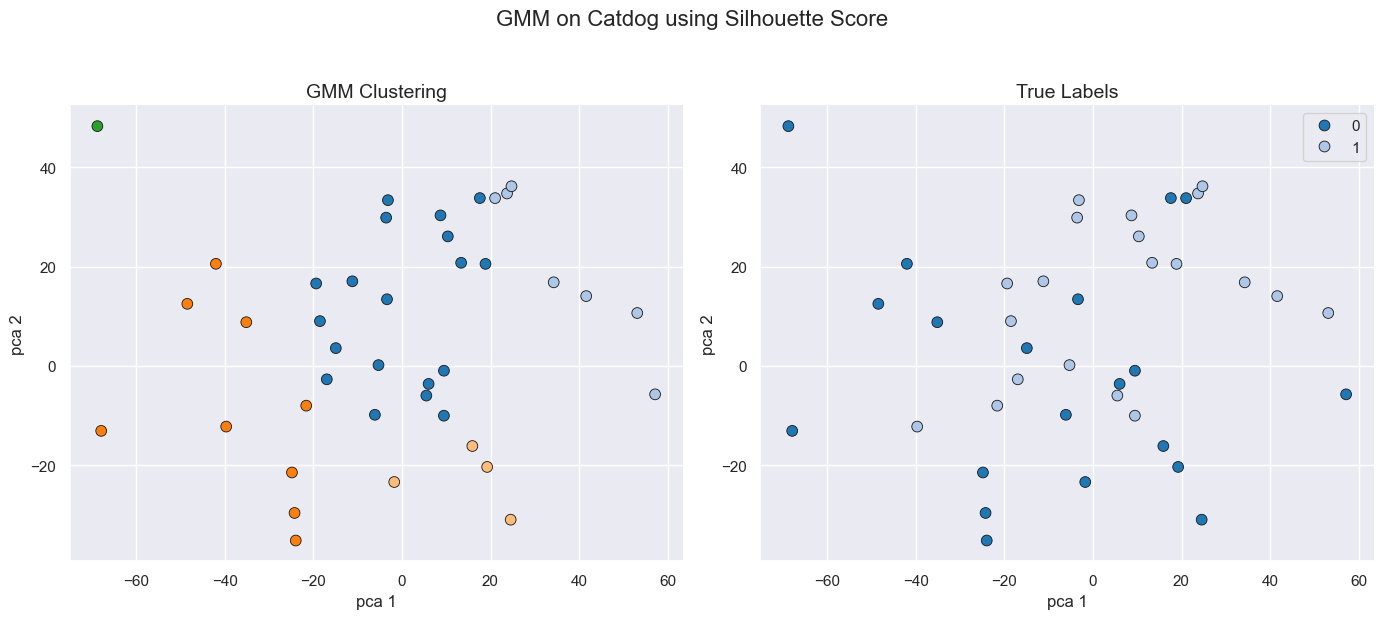

ARI: 0.1103943605772428


C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:35: UserWarning: The palette list has more values (20) than needed (4), which may not be intended.
  sns.scatterplot(
C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:47: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.scatterplot(


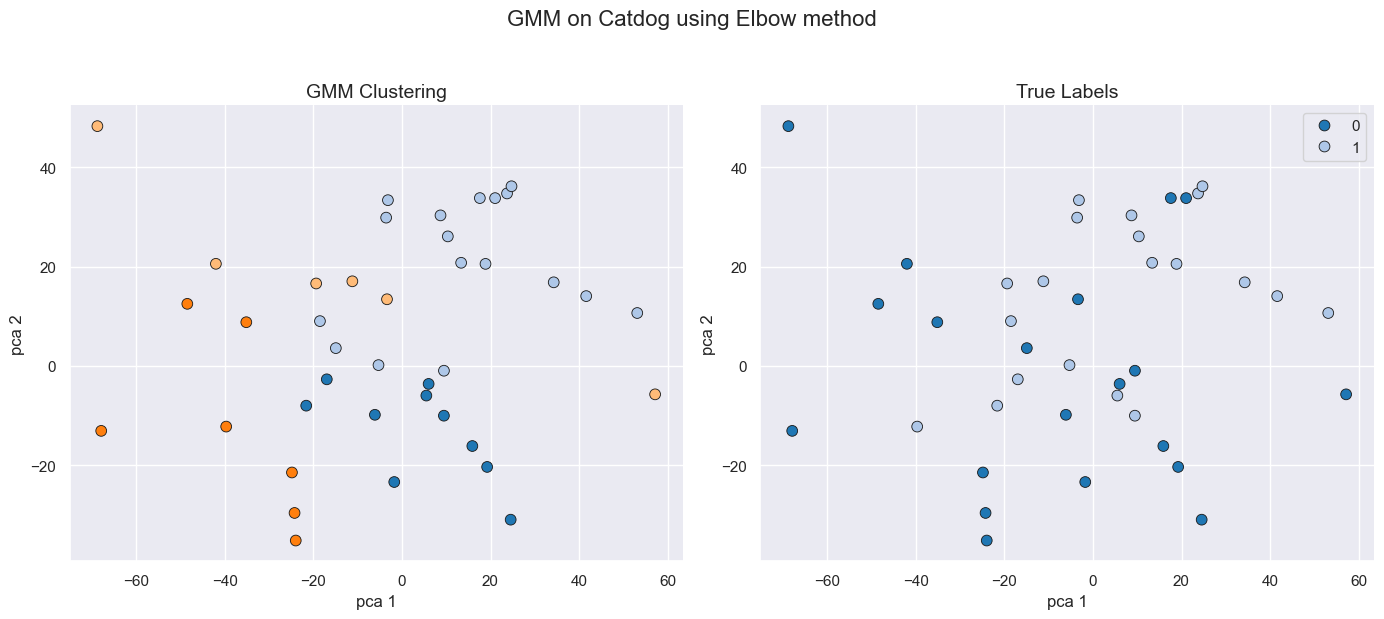

In [346]:
gmm_catdog = GaussianMixture(n_components=most_frequent_k_ss).fit(X_catdog_train)
y_catdog_pred = gmm_catdog.predict(X_catdog_test)
ari_catdog = adjusted_rand_score(y_catdog_test, y_catdog_pred)
print(f"ARI: {ari_catdog}")
plot_gmm_and_true_labels(X_catdog_test,y_catdog_pred, y_catdog_test, gmm_catdog, title="GMM on Catdog using Silhouette Score")


gmm_catdog = GaussianMixture(n_components=most_frequent_k_elbow).fit(X_catdog_train)
y_catdog_pred = gmm_catdog.predict(X_catdog_test)
ari_catdog = adjusted_rand_score(y_catdog_test, y_catdog_pred)
print(f"ARI: {ari_catdog}")
plot_gmm_and_true_labels(X_catdog_test,y_catdog_pred, y_catdog_test, gmm_catdog, title="GMM on Catdog using Elbow method")

### Test for 50D projections

In [348]:
pca_catdog50 = PCA(n_components=50, random_state=42)
X_catdog_pca50 = pca_catdog50.fit_transform(X_catdog)

# pca 2D projection of MNIST data set
pca_mnist50 = PCA(n_components=50, random_state=42)
X_mnist_pca50 = pca_mnist50.fit_transform(X_mnist)

X_catdog_train50, X_catdog_test50, y_catdog_train50, y_catdog_test50 = train_test_split(
    X_catdog_pca50, y_catdog, test_size=0.2, random_state=42, stratify=y_catdog
)

# Split MNIST dataset
X_mnist_train50, X_mnist_test50, y_mnist_train50, y_mnist_test50 = train_test_split(
    X_mnist_pca50, y_mnist, test_size=0.2, random_state=42, stratify=y_mnist
)


In [349]:
aris_ss_catdog50, k_best_ss_catdog50, aris_elbow_catdog50 , k_best_elbow_catdog50, df_runs_catdog50 = assess_tuning_stability(X_catdog_train50, [x for x in range(1,10)], 10, 5)

aris_ss_mnist50, k_best_ss_mnist50, aris_elbow_mnist50 , k_best_elbow_mnist50, df_runs_mnist50 = assess_tuning_stability(X_mnist_train50, [x for x in range(6,30)], 10, 5)


C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\3178203667.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, df_temp_tune], ignore_index=True)


##### Metrics using Silhouette score: #####
Average ARI across 10 tuning runs: -0.0011
Best k's across runs: [np.int64(2), np.int64(2), np.int64(2), np.int64(9), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2)]
##### Metrics using Elbow method: #####
Average ARI across 10 tuning runs: -0.0018
Best k's across runs: [np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(4), np.int64(4), np.int64(3), np.int64(3), np.int64(3), np.int64(3)]


C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\3178203667.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, df_temp_tune], ignore_index=True)


##### Metrics using Silhouette score: #####
Average ARI across 10 tuning runs: 0.0006
Best k's across runs: [np.int64(27), np.int64(29), np.int64(19), np.int64(26), np.int64(21), np.int64(22), np.int64(9), np.int64(19), np.int64(21), np.int64(12)]
##### Metrics using Elbow method: #####
Average ARI across 10 tuning runs: 0.0001
Best k's across runs: [np.int64(15), np.int64(12), np.int64(12), np.int64(14), np.int64(15), np.int64(12), np.int64(13), np.int64(15), np.int64(14), np.int64(12)]


# Validation

### MNIST

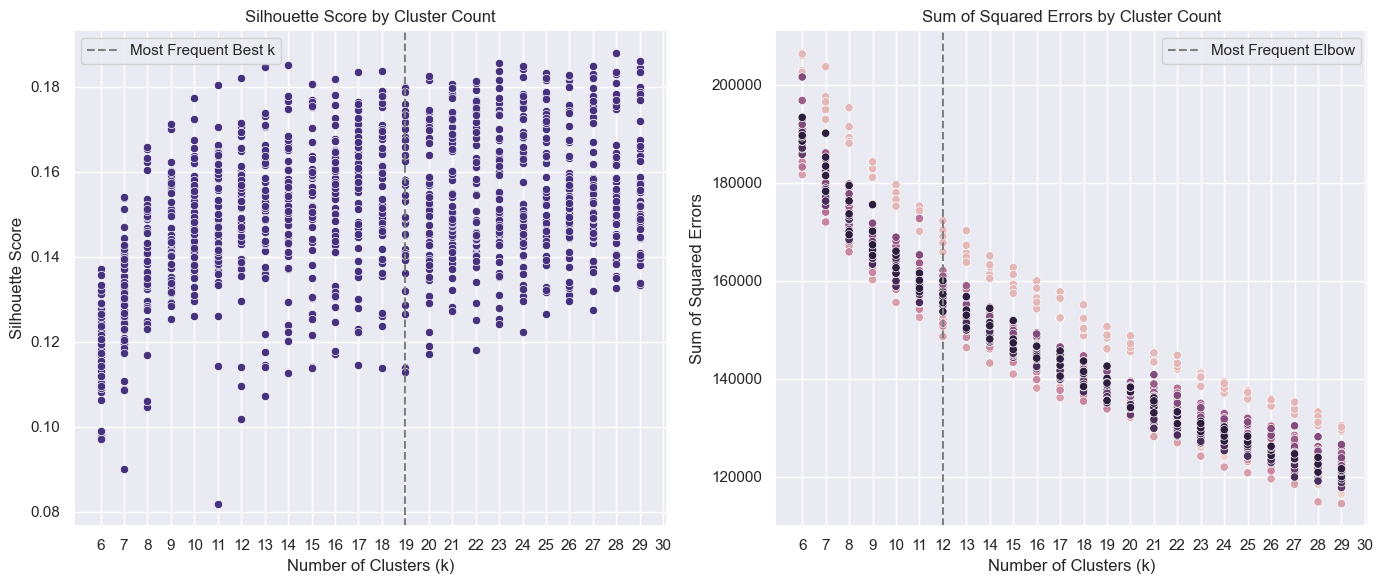

In [350]:
values, counts = np.unique(k_best_ss_mnist50, return_counts=True)
most_frequent_k_ss = values[np.argmax(counts)]

values, counts = np.unique(k_best_elbow_mnist50, return_counts=True)
most_frequent_k_elbow = values[np.argmax(counts)]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

xticks_range = list(range(6, 31))

sns.scatterplot(data=df_runs_mnist50, x='n_clusters', y='silhouette', marker='o', ax=ax1, legend=False)
ax1.axvline(most_frequent_k_ss, color='gray', linestyle='--', label='Most Frequent Best k')
ax1.set_title('Silhouette Score by Cluster Count')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.legend()
ax1.set_xticks(xticks_range)

# Plot 2: Sum of Squared Errors
sns.scatterplot(data=df_runs_mnist50, x='n_clusters', y='sum_sq_error', hue="run", marker='o', ax=ax2, legend=False)
ax2.axvline(most_frequent_k_elbow, color='gray', linestyle='--', label='Most Frequent Elbow')
ax2.set_title('Sum of Squared Errors by Cluster Count')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Sum of Squared Errors')
ax2.legend()
ax2.set_xticks(xticks_range)

plt.tight_layout()
plt.show()


ARI using Silhouette: 0.5026412637612581


C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:35: UserWarning: The palette list has more values (20) than needed (14), which may not be intended.
  sns.scatterplot(
C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:47: UserWarning: The palette list has more values (20) than needed (9), which may not be intended.
  sns.scatterplot(


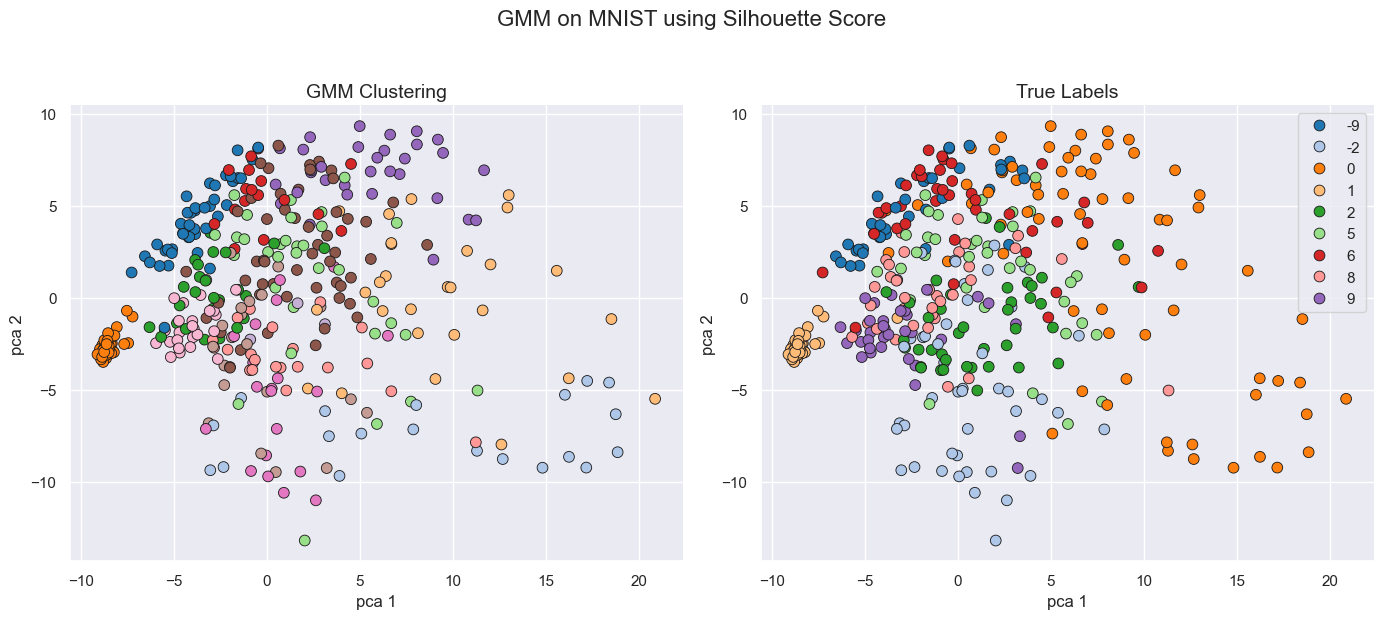

ARI using Elbow: 0.5361620617413598


C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:35: UserWarning: The palette list has more values (20) than needed (12), which may not be intended.
  sns.scatterplot(
C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:47: UserWarning: The palette list has more values (20) than needed (9), which may not be intended.
  sns.scatterplot(


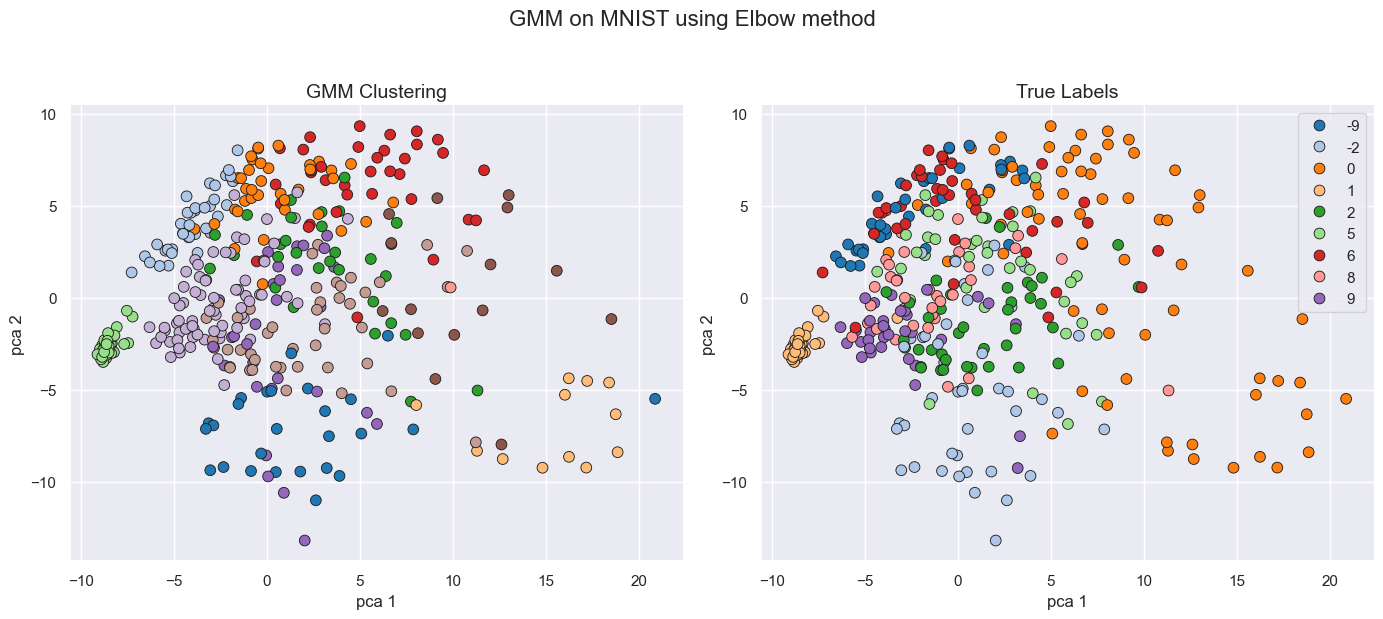

In [351]:
gmm_mnist50 = GaussianMixture(n_components=most_frequent_k_ss).fit(X_mnist_train50)
y_mnist_pred50 = gmm_mnist50.predict(X_mnist_test50)
ari_mnist50 = adjusted_rand_score(y_mnist_test50, y_mnist_pred50)
print(f"ARI using Silhouette: {ari_mnist50}")
plot_gmm_and_true_labels(X_mnist_test50,y_mnist_pred50, y_mnist_test50, gmm_mnist50, title="GMM on MNIST using Silhouette Score")

gmm_mnist50 = GaussianMixture(n_components=most_frequent_k_elbow).fit(X_mnist_train50)
y_mnist_pred50 = gmm_mnist50.predict(X_mnist_test50)
ari_mnist50 = adjusted_rand_score(y_mnist_test50, y_mnist_pred50)
print(f"ARI using Elbow: {ari_mnist50}")
plot_gmm_and_true_labels(X_mnist_test50,y_mnist_pred50, y_mnist_test50, gmm_mnist50, title="GMM on MNIST using Elbow method")



### CATDOG

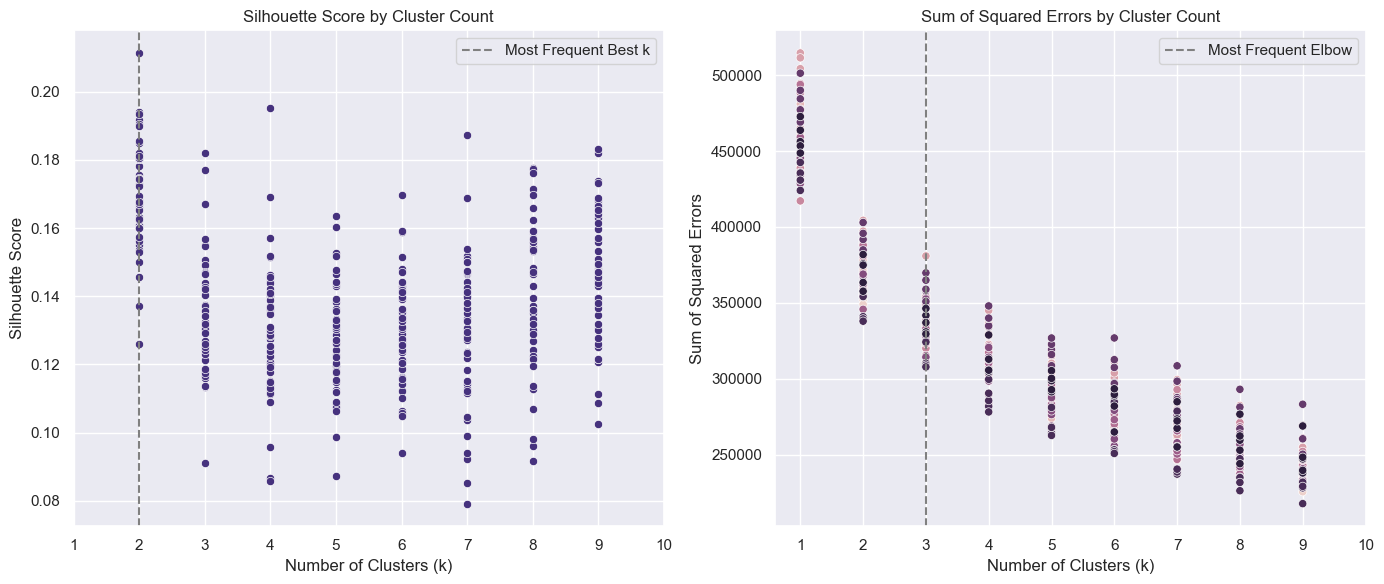

In [352]:
values, counts = np.unique(k_best_ss_catdog50, return_counts=True)
most_frequent_k_ss = values[np.argmax(counts)]

values, counts = np.unique(k_best_elbow_catdog50, return_counts=True)
most_frequent_k_elbow = values[np.argmax(counts)]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

xticks_range = list(range(1, 11))

sns.scatterplot(data=df_runs_catdog50, x='n_clusters', y='silhouette', marker='o', ax=ax1, legend=False)
ax1.axvline(most_frequent_k_ss, color='gray', linestyle='--', label='Most Frequent Best k')
ax1.set_title('Silhouette Score by Cluster Count')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.legend()
ax1.set_xticks(xticks_range)

# Plot 2: Sum of Squared Errors
sns.scatterplot(data=df_runs_catdog50, x='n_clusters', y='sum_sq_error', hue="run", marker='o', ax=ax2, legend=False)
ax2.axvline(most_frequent_k_elbow, color='gray', linestyle='--', label='Most Frequent Elbow')
ax2.set_title('Sum of Squared Errors by Cluster Count')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Sum of Squared Errors')
ax2.legend()
ax2.set_xticks(xticks_range)

plt.tight_layout()
plt.show()

ARI: -0.0220125786163522


C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:35: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.scatterplot(
C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:47: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.scatterplot(


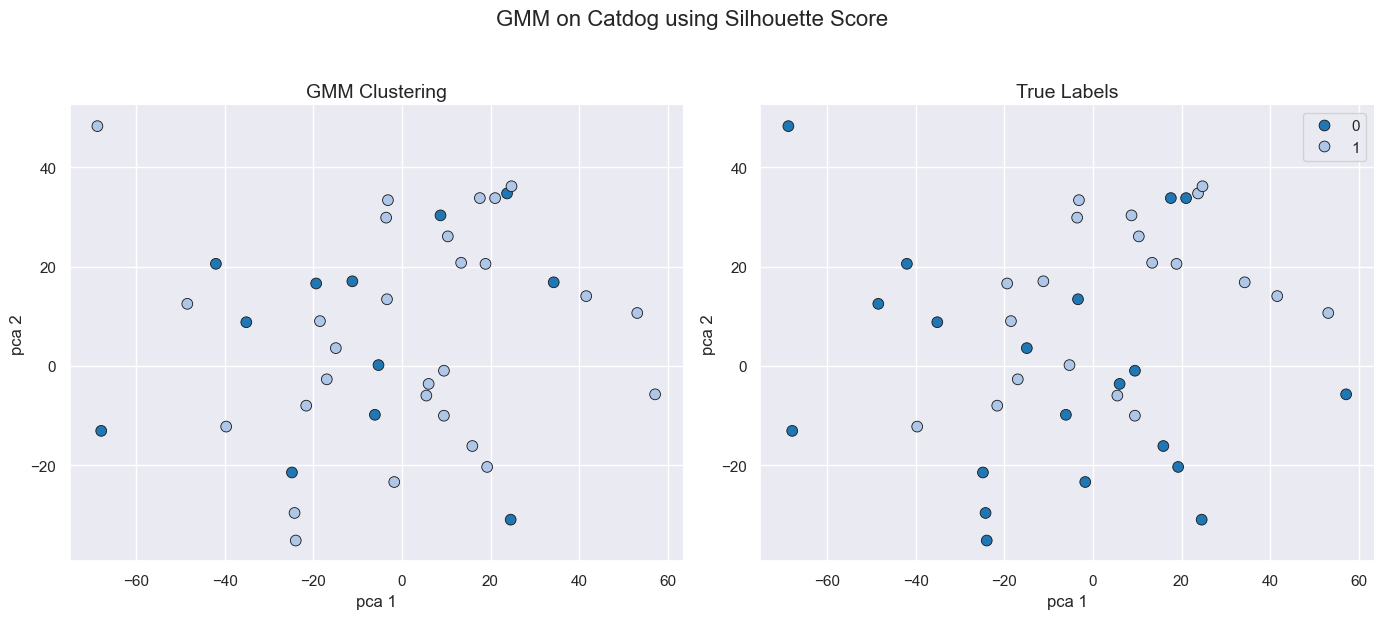

ARI: 0.03839831678611349


C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:35: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.scatterplot(
C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:47: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.scatterplot(


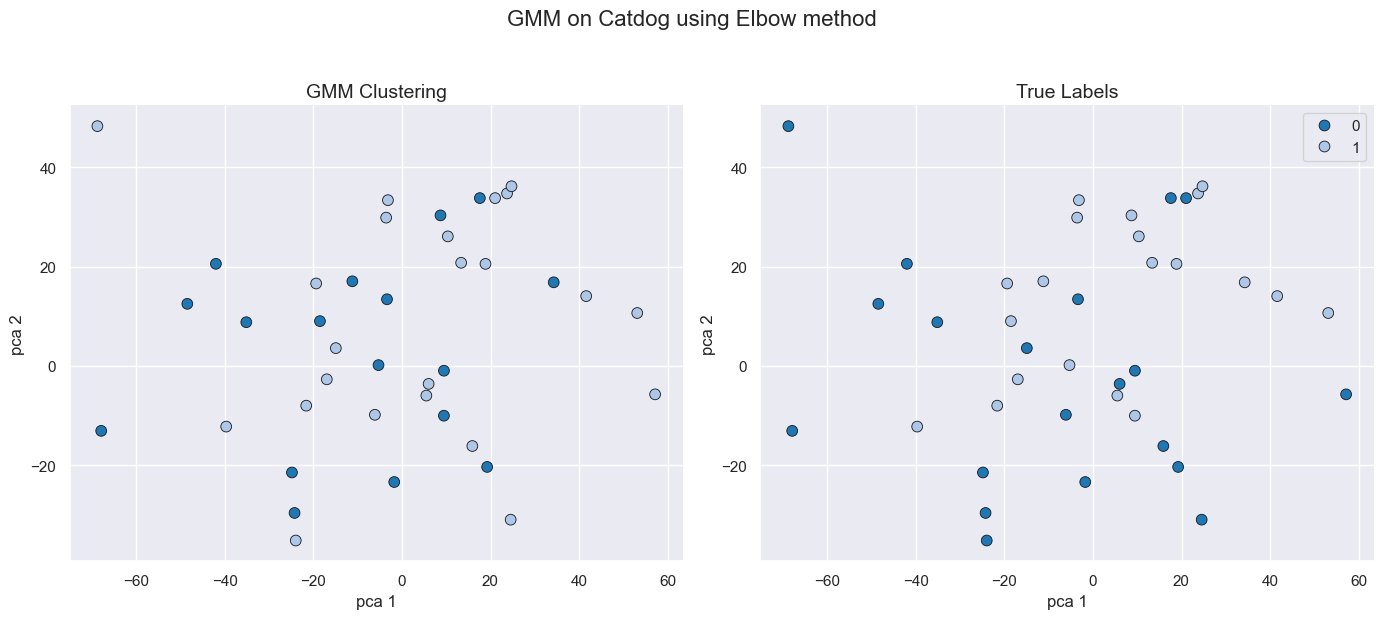

In [353]:
gmm_catdog50 = GaussianMixture(n_components=most_frequent_k_ss).fit(X_catdog_train50)
y_catdog_pred50 = gmm_catdog50.predict(X_catdog_test50)
ari_catdog50 = adjusted_rand_score(y_catdog_test50, y_catdog_pred50)
print(f"ARI: {ari_catdog50}")
plot_gmm_and_true_labels(X_catdog_test50,y_catdog_pred50, y_catdog_test50, gmm_catdog50, title="GMM on Catdog using Silhouette Score")


gmm_catdog50 = GaussianMixture(n_components=most_frequent_k_elbow).fit(X_catdog_train50)
y_catdog_pred50 = gmm_catdog50.predict(X_catdog_test50)
ari_catdog50 = adjusted_rand_score(y_catdog_test50, y_catdog_pred50)
print(f"ARI: {ari_catdog50}")
plot_gmm_and_true_labels(X_catdog_test50,y_catdog_pred50, y_catdog_test50, gmm_catdog50, title="GMM on Catdog using Elbow method")

### Catdog 150


In [369]:
pca_catdog150 = PCA(n_components=25, random_state=42)
X_catdog_pca150 = pca_catdog150.fit_transform(X_catdog)

X_catdog_train150, X_catdog_test150, y_catdog_train150, y_catdog_test150 = train_test_split(
    X_catdog_pca150, y_catdog, test_size=0.2, random_state=42, stratify=y_catdog
)

aris_ss_catdog150, k_best_ss_catdog150, aris_elbow_catdog150 , k_best_elbow_catdog150, df_runs_catdog150 = assess_tuning_stability(X_catdog_train150, [x for x in range(1,10)], 10, 5)


C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\3178203667.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, df_temp_tune], ignore_index=True)


##### Metrics using Silhouette score: #####
Average ARI across 10 tuning runs: -0.0012
Best k's across runs: [np.int64(2), np.int64(2), np.int64(2), np.int64(9), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2)]
##### Metrics using Elbow method: #####
Average ARI across 10 tuning runs: 0.0009
Best k's across runs: [np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(4), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3)]


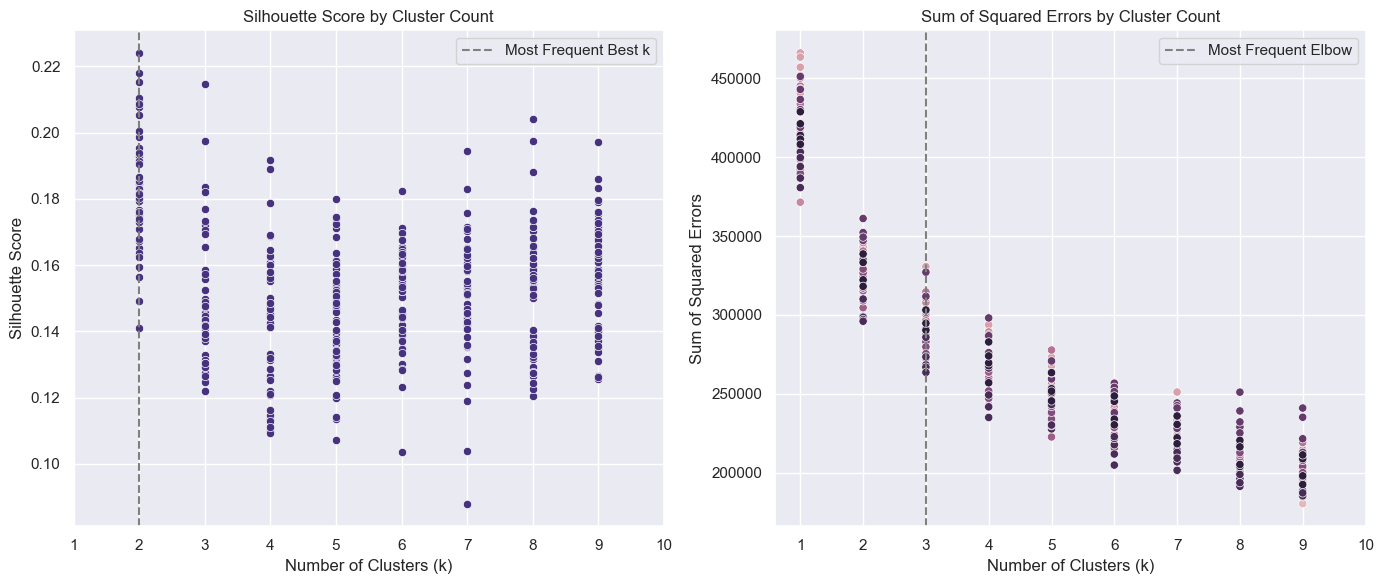

In [370]:
values, counts = np.unique(k_best_ss_catdog150, return_counts=True)
most_frequent_k_ss = values[np.argmax(counts)]

values, counts = np.unique(k_best_elbow_catdog150, return_counts=True)
most_frequent_k_elbow = values[np.argmax(counts)]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

xticks_range = list(range(1, 11))

sns.scatterplot(data=df_runs_catdog150, x='n_clusters', y='silhouette', marker='o', ax=ax1, legend=False)
ax1.axvline(most_frequent_k_ss, color='gray', linestyle='--', label='Most Frequent Best k')
ax1.set_title('Silhouette Score by Cluster Count')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.legend()
ax1.set_xticks(xticks_range)

# Plot 2: Sum of Squared Errors
sns.scatterplot(data=df_runs_catdog150, x='n_clusters', y='sum_sq_error', hue="run", marker='o', ax=ax2, legend=False)
ax2.axvline(most_frequent_k_elbow, color='gray', linestyle='--', label='Most Frequent Elbow')
ax2.set_title('Sum of Squared Errors by Cluster Count')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Sum of Squared Errors')
ax2.legend()
ax2.set_xticks(xticks_range)

plt.tight_layout()
plt.show()

ARI: 0.06629834254143646


C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:35: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.scatterplot(
C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:47: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.scatterplot(


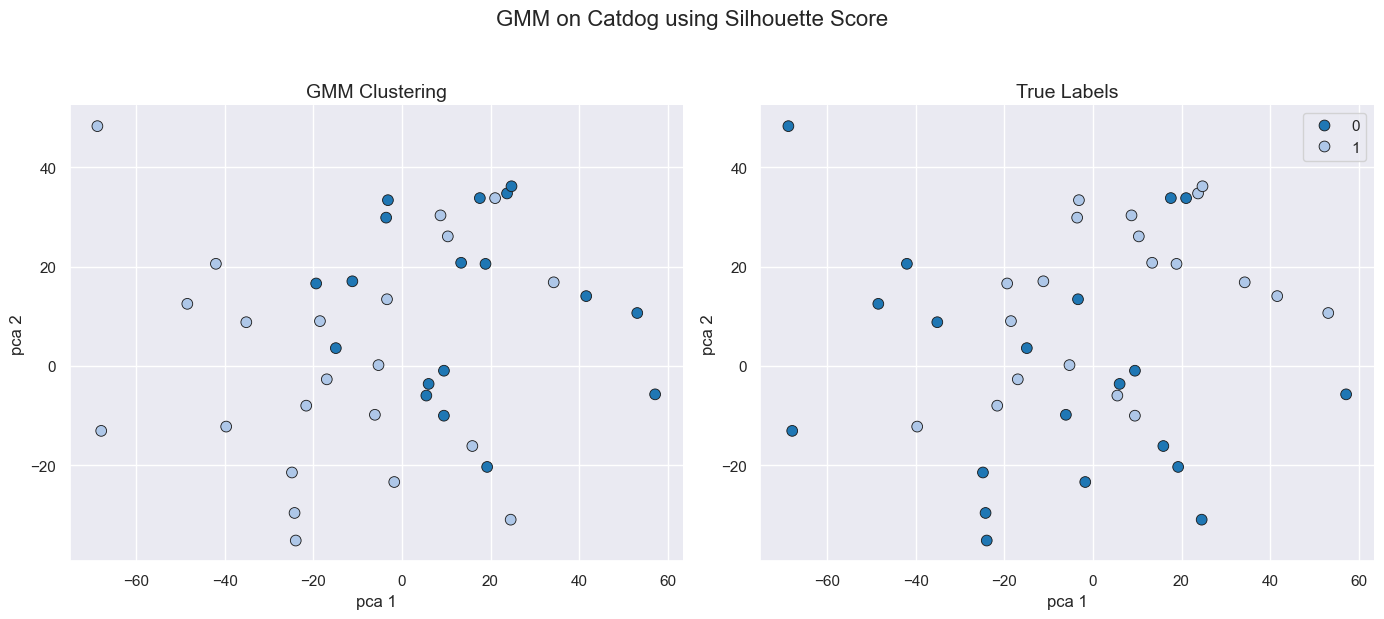

ARI: 0.09169929002720456


C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:35: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.scatterplot(
C:\Users\maxfr\AppData\Local\Temp\ipykernel_11920\1732603401.py:47: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.scatterplot(


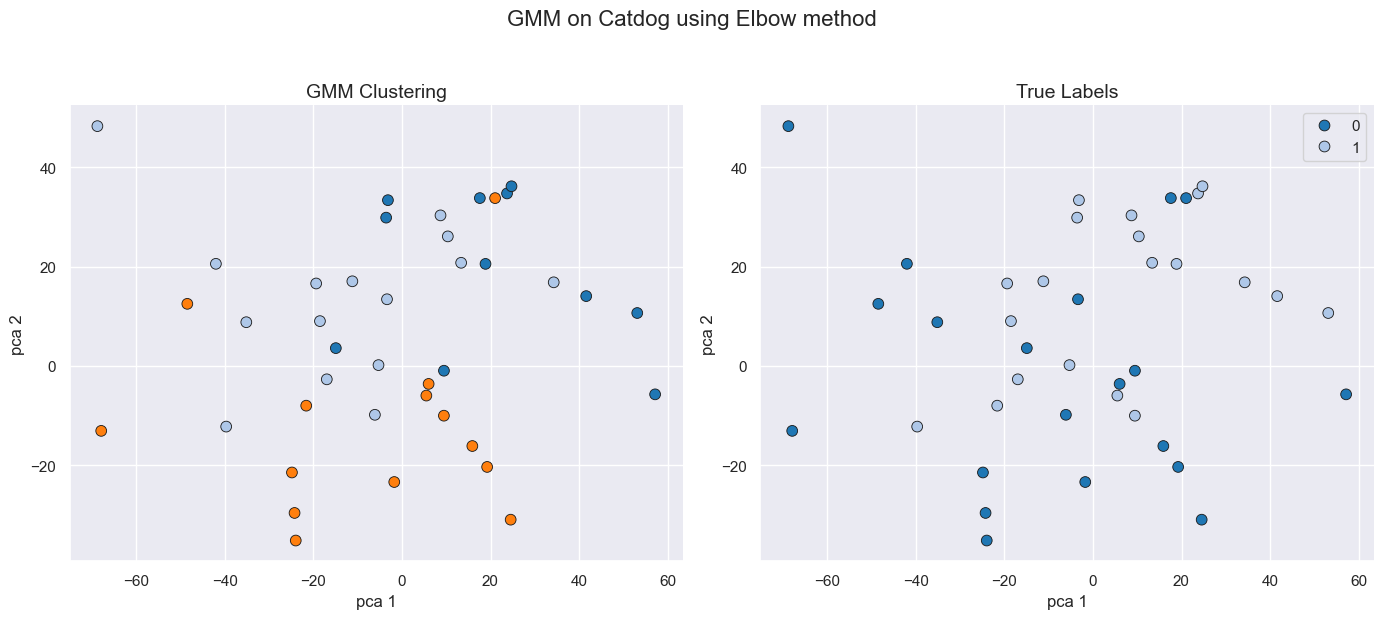

In [371]:
gmm_catdog150 = GaussianMixture(n_components=most_frequent_k_ss).fit(X_catdog_train150)
y_catdog_pred150 = gmm_catdog150.predict(X_catdog_test150)
ari_catdog150 = adjusted_rand_score(y_catdog_test150, y_catdog_pred150)
print(f"ARI: {ari_catdog150}")
plot_gmm_and_true_labels(X_catdog_test150,y_catdog_pred150, y_catdog_test150, gmm_catdog150, title="GMM on Catdog using Silhouette Score")


gmm_catdog150 = GaussianMixture(n_components=most_frequent_k_elbow).fit(X_catdog_train150)
y_catdog_pred150 = gmm_catdog150.predict(X_catdog_test150)
ari_catdog150 = adjusted_rand_score(y_catdog_test150, y_catdog_pred150)
print(f"ARI: {ari_catdog150}")
plot_gmm_and_true_labels(X_catdog_test150,y_catdog_pred150, y_catdog_test150, gmm_catdog150, title="GMM on Catdog using Elbow method")